In [2]:
import sys
import csv
import numpy as np
import emoji
import pandas as pd
import emo_utils as utils
import matplotlib.pyplot as plt

def word_embedding(train_X):
    new_train_X = []
    for sentence in train_X:
        temp = sentence.split()
        result = []
        for word in temp:
            word = word.lower()
            result.append(word_to_vec_map[word])
        new_train_X.append(result)
    return new_train_X

In [2]:
train_X, train_Y = utils.read_csv("train_emoji.csv")
test_X, test_Y = utils.read_csv("test_emoji.csv")
words_to_index, index_to_words, word_to_vec_map = utils.read_glove_vecs("glove.6B.50d.txt")

In [3]:
embedded_train_X = word_embedding(train_X)
embedded_test_X = word_embedding(test_X)

In [17]:
print(train_X[0])
print(len(train_Y))
print(len(test_Y))

never talk to me again
132
56


In [5]:
class Sigmoid:
    def forward(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def backward(self, x, top_diff):
        output = self.forward(x)
        return (1.0 - output) * output * top_diff

class Tanh:
    def forward(self, x):
        return np.tanh(x)

    def backward(self, x, top_diff):
        output = self.forward(x)
        return (1.0 - np.square(output)) * top_diff

In [6]:
class MultiplyGate:
    def forward(self,W, x):
        return np.dot(W, x)

    def backward(self, W, x, dz):
        dW = np.asarray(np.dot(np.transpose(np.asmatrix(dz)), np.asmatrix(x)))
        dx = np.dot(np.transpose(W), dz)
        return dW, dx

class AddGate:
    def forward(self, x1, x2):
        return x1 + x2

    def backward(self, x1, x2, dz):
        dx1 = dz * np.ones_like(x1)
        dx2 = dz * np.ones_like(x2)
        return dx1, dx2

In [7]:
mulGate = MultiplyGate()
addGate = AddGate()
activation = Tanh()

class RNNLayer:
    def forward(self, x, prev_s, U, W, V):
        self.mulu = mulGate.forward(U, x)
        self.mulw = mulGate.forward(W, prev_s)
        self.add = addGate.forward(self.mulw, self.mulu)
        self.s = activation.forward(self.add)
        self.mulv = mulGate.forward(V, self.s)
        #print("self.s.shape", self.s.shape)
        #print("RNN forward result: ", self.mulv.shape)

    def backward(self, x, prev_s, U, W, V, diff_s, dmulv):
        self.forward(x, prev_s, U, W, V)
        dV, dsv = mulGate.backward(V, self.s, dmulv)
        ds = dsv + diff_s
        dadd = activation.backward(self.add, ds)
        dmulw, dmulu = addGate.backward(self.mulw, self.mulu, dadd)
        dW, dprev_s = mulGate.backward(W, prev_s, dmulw)
        dU, dx = mulGate.backward(U, x, dmulu)
        return (dprev_s, dU, dW, dV)
    
class Linear:
    def __init__(self, input_size, output_size):
        self.info = "Linear Layer"
        self.weights = np.random.randn(input_size, output_size) * 0.1
        self.biases = np.zeros(output_size)
        self.learning_rate = 0.5
        self.last_input_shape = None
        self.last_input = None
        self.last_output = None

    def forward(self, input):
        self.last_input_shape = input.shape
        input = input.flatten()
        output = np.dot(input, self.weights) + self.biases

        self.last_input = input
        self.last_output = output
        return np.exp(output) / np.sum(np.exp(output), axis=0)

    def backward(self, din):
        for i, gradient in enumerate(din):
            if gradient == 0:
                continue

            t_exp = np.exp(self.last_output)
            dout_dt = -t_exp[i] * t_exp / (np.sum(t_exp) ** 2)
            dout_dt[i] = t_exp[i] * (np.sum(t_exp) - t_exp[i]) / (np.sum(t_exp) ** 2)

            dt = gradient * dout_dt

            dout = self.weights @ dt

            self.weights -= self.learning_rate * (np.transpose(self.last_input[np.newaxis]) @ dt[np.newaxis])
            self.biases -= self.learning_rate * dt

            return dout.reshape(self.last_input_shape)

    def get_weights(self):
        return np.reshape(self.weights, -1)

In [8]:
class Softmax:
    def predict(self, x):
        exp_scores = np.exp(x)
        return exp_scores / np.sum(exp_scores)

    def loss(self, x, y):
        probs = self.predict(x)
        return -np.log(probs[y])

    def diff(self, x, y):
        probs = self.predict(x)
        #probs[y] -= 1.0
        probs = x - y
        return probs

In [9]:
a = np.random.uniform(0, 1, (2,3))
print(a)
print(embedded_test_X[0][0])

[[0.98884662 0.31707163 0.43547845]
 [0.13334591 0.37768065 0.04957284]]
[ 1.1891e-01  1.5255e-01 -8.2073e-02 -7.4144e-01  7.5917e-01 -4.8328e-01
 -3.1009e-01  5.1476e-01 -9.8708e-01  6.1757e-04 -1.5043e-01  8.3770e-01
 -1.0797e+00 -5.1460e-01  1.3188e+00  6.2007e-01  1.3779e-01  4.7108e-01
 -7.2874e-02 -7.2675e-01 -7.4116e-01  7.5263e-01  8.8180e-01  2.9561e-01
  1.3548e+00 -2.5701e+00 -1.3523e+00  4.5880e-01  1.0068e+00 -1.1856e+00
  3.4737e+00  7.7898e-01 -7.2929e-01  2.5102e-01 -2.6156e-01 -3.4684e-01
  5.5841e-01  7.5098e-01  4.9830e-01 -2.6823e-01 -2.7443e-03 -1.8298e-02
 -2.8096e-01  5.5318e-01  3.7706e-02  1.8555e-01 -1.5025e-01 -5.7512e-01
 -2.6671e-01  9.2121e-01]


In [35]:
class Model:
    def __init__(self, word_dim, hidden_dim=100, bptt_truncate=4):
        self.word_dim = word_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        self.U = np.random.uniform(-np.sqrt(1. / word_dim), np.sqrt(1. / word_dim), (hidden_dim, word_dim))
        self.W = np.random.uniform(-np.sqrt(1. / hidden_dim), np.sqrt(1. / hidden_dim), (hidden_dim, hidden_dim))
        self.V = np.random.uniform(-np.sqrt(1. / hidden_dim), np.sqrt(1. / hidden_dim), (word_dim, hidden_dim))
        self.train_loss_log = []
        self.test_loss_log = []
        self.losses = []
        self.log_step = []
        self.Linear = Linear(word_dim, 5)
        
    def visualize_loss(self):
        plt.plot(self.log_step, self.train_loss_log, label='train loss')
        plt.plot(self.log_step, self.test_loss_log, label='validation loss')
        plt.xlabel("num iteration")
        plt.ylabel("loss")
        plt.legend(fontsize='x-large')
        pass
    
    def cross_entropy(self, x):
        return -np.log(x)
    
    # find forward_propagation
    def forward_propagation(self, x):
        # The total number of time steps
        # x = [[50개] [50개] [50개] [50개] [50개]]
        T = len(x) # 5
        layers = []
        prev_s = np.zeros(self.hidden_dim)
        # For each time step...
        for t in range(T):
            # len(x[t]) => 50
            layer = RNNLayer()
            input = x[t]
            layer.forward(input, prev_s, self.U, self.W, self.V)
            layer.input = x[t]
            prev_s = layer.s
            layers.append(layer)
        output = layer.mulv
        result = self.Linear.forward(output)
        return result, layers

    def predict(self, X, Y):
        pred = []
        for x in X:
            result, layers = self.forward_propagation(x)
            pred.append(np.argmax(result))
        acc = 0
        for i in range(len(Y)):
            if pred[i] == Y[i]:
                acc += 1
        acc = acc/len(Y) * 100
        return pred, acc

    def calculate_loss(self, x, y):
        result, layers = self.forward_propagation(x)
        #print("result", result)
        #print("result[y]", result[y])
        return self.cross_entropy(result[y])

    def calculate_total_loss(self, X, Y):
        loss = 0.0
        for i in range(len(Y)):
            loss += self.calculate_loss(X[i], Y[i])
        return loss / float(len(Y))

    # find backpropagation
    def back_propagation(self, x, y):
        result, layers = self.forward_propagation(x)
        gradient = np.zeros(5)
        gradient[y] = -1 / result[y]
        gradient = self.Linear.backward(gradient)
        
        # --> Linear Layer에서 back propagation 함
        output = Softmax()
        dU = np.zeros(self.U.shape)
        dV = np.zeros(self.V.shape)
        dW = np.zeros(self.W.shape)

        T = len(layers) - 1
        prev_s_t = np.zeros(self.hidden_dim)
        diff_s = np.zeros(self.hidden_dim)
        
        for t in range(0, T):
            dmulv = output.diff(layers[t].mulv, gradient)
            input = np.zeros(self.word_dim)
            dprev_s, dU_t, dW_t, dV_t = layers[t].backward(input, prev_s_t, self.U, self.W, self.V, diff_s, dmulv)
            prev_s_t = layers[t].s
            dmulv = np.zeros(self.word_dim)
            for i in range(t-1, max(-1, t-self.bptt_truncate-1), -1):
                input = np.zeros(self.word_dim)
                #input[x[i]] = 1
                input = layers[i].input
                prev_s_i = np.zeros(self.hidden_dim) if i == 0 else layers[i-1].s
                dprev_s, dU_i, dW_i, dV_i = layers[i].backward(input, prev_s_i, self.U, self.W, self.V, dprev_s, dmulv)
                dU_t += dU_i
                dW_t += dW_i
            dV += dV_t
            dU += dU_t
            dW += dW_t
        return (dU, dW, dV)

    def sgd_step(self, x, y, learning_rate):
        dU, dW, dV = self.back_propagation(x, y)
        self.U -= learning_rate * dU
        self.V -= learning_rate * dV
        self.W -= learning_rate * dW

    def train(self, X, Y, test_X, test_Y, learning_rate=0.005, nepoch=100):
        """
        X = [[never talk to me again] ~ [i love you]]
        embedded X = [[[0.1, 0.2, ... , 0.1 ], [0.1, 0.2, ... , 0.1 ], [0.1, 0.2, ... , 0.1 ]]         ~ [[] [] []]             ] 
        """
        num_examples_seen = 0
        
        for epoch in range(nepoch):
            if epoch % 10 == 0:
                # 여기서 forward
                train_loss = self.calculate_total_loss(X, Y)
                self.losses.append((num_examples_seen, train_loss))
                self.train_loss_log.append(train_loss)
                test_loss = self.calculate_total_loss(test_X, test_Y)
                self.test_loss_log.append(test_loss)
                self.log_step.append(epoch)
                #print("loss", loss)
                print("[Loss after epoch=%d] train loss: %f, test loss: %f" % (epoch, train_loss, test_loss))
                
            # For each training example...
            for i in range(len(Y)):
                self.sgd_step(X[i], Y[i], learning_rate)
                num_examples_seen += 1
        print("training done")

In [55]:
word_dim = 50
hidden_dim = 100

np.random.seed(10)
rnn = Model(word_dim, hidden_dim)
rnn.train(embedded_train_X, train_Y, embedded_test_X, test_Y, learning_rate=0.005, nepoch=5000)

[Loss after epoch=0] train loss: 1.631724, test loss: 1.625062
[Loss after epoch=10] train loss: 0.978340, test loss: 1.035046
[Loss after epoch=20] train loss: 1.087604, test loss: 1.188837
[Loss after epoch=30] train loss: 0.925598, test loss: 0.979347
[Loss after epoch=40] train loss: 1.164572, test loss: 1.419573
[Loss after epoch=50] train loss: 1.028679, test loss: 1.243604
[Loss after epoch=60] train loss: 1.068026, test loss: 1.263582
[Loss after epoch=70] train loss: 0.724529, test loss: 0.825077
[Loss after epoch=80] train loss: 0.965887, test loss: 1.066392
[Loss after epoch=90] train loss: 0.795123, test loss: 0.893953
[Loss after epoch=100] train loss: 0.723644, test loss: 0.808951
[Loss after epoch=110] train loss: 0.713910, test loss: 0.761840
[Loss after epoch=120] train loss: 0.890704, test loss: 1.031198
[Loss after epoch=130] train loss: 0.769440, test loss: 0.792611
[Loss after epoch=140] train loss: 0.744104, test loss: 0.968533
[Loss after epoch=150] train loss: 0

[Loss after epoch=1260] train loss: 0.506378, test loss: 0.678630
[Loss after epoch=1270] train loss: 0.505805, test loss: 0.677372
[Loss after epoch=1280] train loss: 0.505260, test loss: 0.676134
[Loss after epoch=1290] train loss: 0.504745, test loss: 0.674919
[Loss after epoch=1300] train loss: 0.504259, test loss: 0.673727
[Loss after epoch=1310] train loss: 0.503802, test loss: 0.672559
[Loss after epoch=1320] train loss: 0.503375, test loss: 0.671417
[Loss after epoch=1330] train loss: 0.502977, test loss: 0.670302
[Loss after epoch=1340] train loss: 0.502607, test loss: 0.669213
[Loss after epoch=1350] train loss: 0.502266, test loss: 0.668153
[Loss after epoch=1360] train loss: 0.501953, test loss: 0.667121
[Loss after epoch=1370] train loss: 0.501668, test loss: 0.666117
[Loss after epoch=1380] train loss: 0.501409, test loss: 0.665143
[Loss after epoch=1390] train loss: 0.501178, test loss: 0.664198
[Loss after epoch=1400] train loss: 0.500972, test loss: 0.663282
[Loss afte

[Loss after epoch=2510] train loss: 0.476717, test loss: 0.617613
[Loss after epoch=2520] train loss: 0.476594, test loss: 0.617535
[Loss after epoch=2530] train loss: 0.476475, test loss: 0.617462
[Loss after epoch=2540] train loss: 0.476361, test loss: 0.617393
[Loss after epoch=2550] train loss: 0.476251, test loss: 0.617329
[Loss after epoch=2560] train loss: 0.476145, test loss: 0.617269
[Loss after epoch=2570] train loss: 0.476043, test loss: 0.617214
[Loss after epoch=2580] train loss: 0.475946, test loss: 0.617162
[Loss after epoch=2590] train loss: 0.475852, test loss: 0.617114
[Loss after epoch=2600] train loss: 0.475763, test loss: 0.617069
[Loss after epoch=2610] train loss: 0.475678, test loss: 0.617029
[Loss after epoch=2620] train loss: 0.475598, test loss: 0.616991
[Loss after epoch=2630] train loss: 0.475521, test loss: 0.616957
[Loss after epoch=2640] train loss: 0.475449, test loss: 0.616927
[Loss after epoch=2650] train loss: 0.475380, test loss: 0.616899
[Loss afte

[Loss after epoch=3760] train loss: 0.464979, test loss: 0.607143
[Loss after epoch=3770] train loss: 0.464895, test loss: 0.606993
[Loss after epoch=3780] train loss: 0.464812, test loss: 0.606843
[Loss after epoch=3790] train loss: 0.464731, test loss: 0.606695
[Loss after epoch=3800] train loss: 0.464653, test loss: 0.606547
[Loss after epoch=3810] train loss: 0.464577, test loss: 0.606402
[Loss after epoch=3820] train loss: 0.464502, test loss: 0.606257
[Loss after epoch=3830] train loss: 0.464430, test loss: 0.606114
[Loss after epoch=3840] train loss: 0.464360, test loss: 0.605972
[Loss after epoch=3850] train loss: 0.464292, test loss: 0.605831
[Loss after epoch=3860] train loss: 0.464226, test loss: 0.605692
[Loss after epoch=3870] train loss: 0.464162, test loss: 0.605554
[Loss after epoch=3880] train loss: 0.464100, test loss: 0.605418
[Loss after epoch=3890] train loss: 0.464040, test loss: 0.605284
[Loss after epoch=3900] train loss: 0.463983, test loss: 0.605151
[Loss afte

In [31]:
def pred_to_emoji(pred):
    for i in pred:
        print(utils.label_to_emoji(i), end=" ")

In [1]:
pred, acc = rnn.predict(embedded_test_X, test_Y)
print("RNN model accuracy for test set is "+ str(acc)+"%")

RNN model accuracy for test set is 70.28%


In [46]:
pred_to_emoji(pred)

🍴 😞 😄 😄 😞 😄 😞 😄 🍴 😄 ⚾ 😞 😞 😞 ⚾ 😞 😞 ❤️ 😞 🍴 ❤️ 😄 🍴 😞 😞 😞 ⚾ ❤️ ⚾ 😄 ❤️ ⚾ 😞 😄 😄 ⚾ 😞 🍴 🍴 😄 ⚾ ❤️ ❤️ ⚾ 😞 😞 😄 😄 😄 😞 😞 ❤️ 😞 😞 😄 🍴 

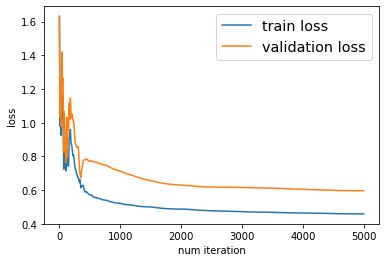

In [25]:
rnn.visualize_loss()